# Exploratory Data Analysis

This notebook will go through the exploratory data analysis of the data. I will ask questions based on my learnings in research papers and explore the data.

In [24]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import sqlalchemy
from transformers import pipeline, RobertaTokenizer
from tqdm import tqdm

# Adding the credentials
sys.path.append('../')
from credentials import credentials

In [2]:
# Creating the database engine 
connector_string = f'mysql+mysqlconnector://{credentials["user"]}:{credentials["password"]}@{credentials["host"]}/AuthenticAI'
db_engine = sqlalchemy.create_engine(connector_string,echo=True)

# Connecting to the database
db_conn = db_engine.connect()

2024-01-07 23:23:03,662 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2024-01-07 23:23:03,663 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-01-07 23:23:03,666 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2024-01-07 23:23:03,667 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-01-07 23:23:03,669 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2024-01-07 23:23:03,670 INFO sqlalchemy.engine.Engine [raw sql] {}


## What is the distribution of the labels? How many student written essays are there? How many LLM generated essays? Is there an imbalance?

In [3]:
student_written_count = [i[0] for i in db_conn.execute(sqlalchemy.text('select count(*) from essays where essays.LLM_written = 0;'))][0]
llm_written_count = [i[0] for i in db_conn.execute(sqlalchemy.text('select count(*) from essays where essays.LLM_written = 1;'))][0]

2024-01-07 23:23:06,155 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-01-07 23:23:06,169 INFO sqlalchemy.engine.Engine select count(*) from essays where essays.LLM_written = 0;
2024-01-07 23:23:06,171 INFO sqlalchemy.engine.Engine [generated in 0.01730s] {}
2024-01-07 23:23:06,733 INFO sqlalchemy.engine.Engine select count(*) from essays where essays.LLM_written = 1;
2024-01-07 23:23:06,734 INFO sqlalchemy.engine.Engine [generated in 0.00106s] {}


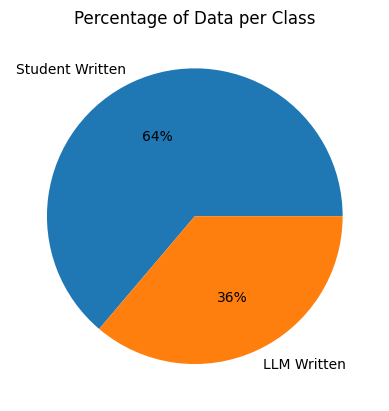

In [4]:
# Plotting the numbers in a pie chart
classes = ['Student Written','LLM Written']
data = [student_written_count, llm_written_count]

plt.pie(x=data,labels=classes,autopct='%.0f%%')
plt.title('Percentage of Data per Class')
plt.show()

## What is the mean, median, and standard deviation of the number of words per each class? Is there a significant difference?

In [5]:
word_counts = pd.DataFrame([i for i in db_conn.execute(sqlalchemy.text('select word_count, LLM_written from essays;'))])

2024-01-07 23:23:10,361 INFO sqlalchemy.engine.Engine select word_count, LLM_written from essays;
2024-01-07 23:23:10,363 INFO sqlalchemy.engine.Engine [generated in 0.00229s] {}


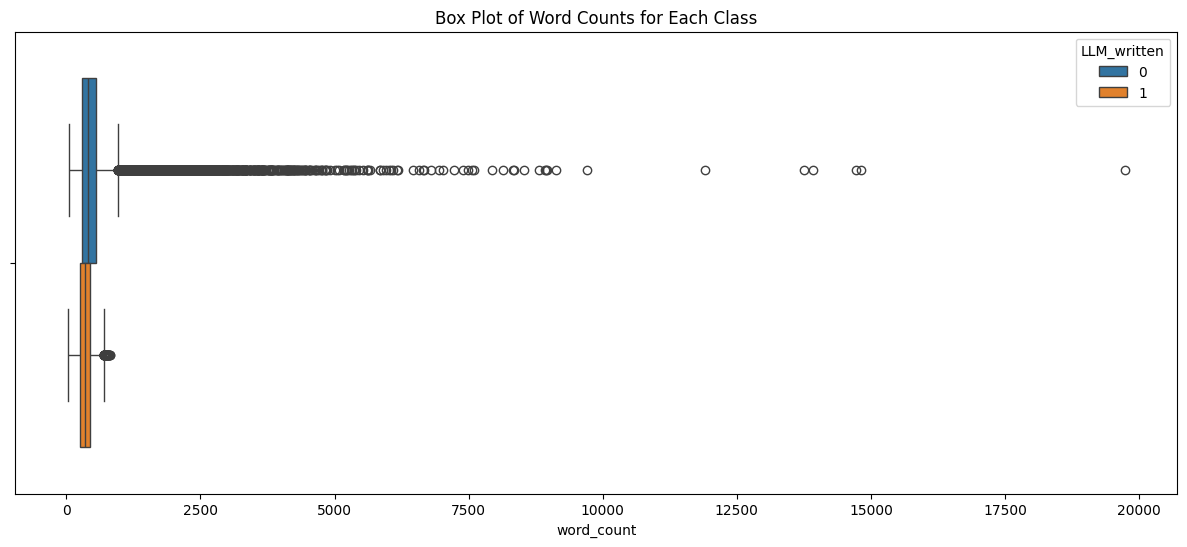

In [6]:
plt.figure(figsize=(15,6))
sns.boxplot(data=word_counts,x='word_count',hue='LLM_written')
plt.title('Box Plot of Word Counts for Each Class')
plt.show()

Figure isn't great due to various outliers in the student written essays. Perhaps plotting distributions could help.

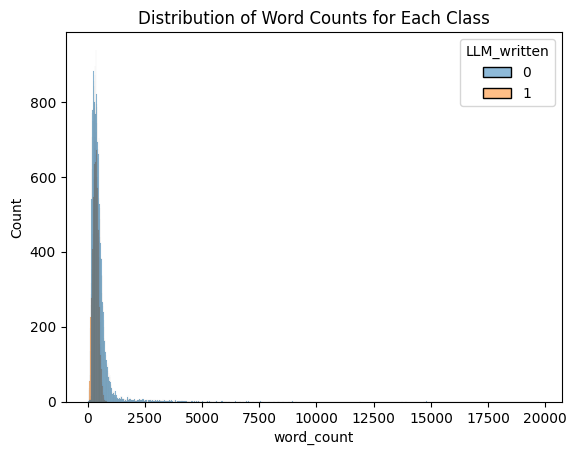

In [7]:
plt.title('Distribution of Word Counts for Each Class')
sns.histplot(data=word_counts,x='word_count',hue='LLM_written')
plt.show()

This plot is a bit better, but not by much. It illustrates that the distribution of student written essays is skewed ,and it looks as the central statistic is bigger. However, the student essays seem to have more standard deviation and variance.

In [8]:
print('Student Written Essay Descriptive Statistics')
print(word_counts[word_counts['LLM_written'] == 0]['word_count'].describe())
print()
print('LLM Written Essay Descriptive Statistics')
print(word_counts[word_counts['LLM_written'] == 1]['word_count'].describe())

Student Written Essay Descriptive Statistics
count    31856.000000
mean       500.700402
std        515.048760
min         48.000000
25%        284.000000
50%        401.000000
75%        558.000000
max      19729.000000
Name: word_count, dtype: float64

LLM Written Essay Descriptive Statistics
count    18073.000000
mean       346.715985
std        124.453252
min         25.000000
25%        258.000000
50%        345.000000
75%        433.000000
max        821.000000
Name: word_count, dtype: float64


The table confirms suspicions that the student written essays tend to have a higher word count than the LLM written essays. If we look at the statistics, we can see that the median number of words for the student written essays is 56 words than the LLM written essays. Furthermore, the maximum number of words in a student written essay is 19729, which is much larger than the maximum number of words in the LLM written essays (821). While the standard deviation for the student written essays is much higher, the median and max count confirm the fact that student written essays tend to have higher word count than LLM written essays. This is a good feature to have for the classical ML models. 

## Can a LLM detect whether an essay is LLM Generated?

In this section, I want to see if a LLM can detect whether an essay was written by a LLM. This question stems from the paper "Will ChatGPT get you caught? Rethinking of Plagiarism Detection". In this paper, the researchers showed that ChatGPT was able to achieve an accuracy of over 92% in detecting whether an essay was written by ChatGPT. However, one cavet of the paper was that the dataset was composed of essays written only by ChatGPT. Furthermore, OpenAI's API is not free, hence I won't be able to test this result and see how it works on my dataset. Fortunately, in the research paper "Release Strategies and the Social Impacts of Language Models", the researchers were able to fine-tune a RoBERTA model to get an accuracy of approximately 95% of this task. An important thing to mention here is that the model was fine-tuned on outputs from GPT-2; however, the model is open source on Hugging Face and free of charge, thus it would be a good idea to test this theory.

In short, in this section, I utilize the RoBERTA Base OpenAI Detector by OpenAI (available on Hugging Face) to see if a LLM can detect whether an essay was written by a LLM. The results of this experiment will be interesting as this model has been trained to detect text written by GPT-2 ,and my data contains essays written from a variety of LLMs.

In [9]:
# Getting the model and tokenizer
detector = pipeline("text-classification","roberta-base-openai-detector")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
# Getting the text and corresponding labels
text_and_labels = pd.DataFrame([i for i in db_conn.execute(sqlalchemy.text('select essay, LLM_written from essays;'))])
text_list = text_and_labels['essay'].tolist() # converting the text to a list

2024-01-07 23:23:37,326 INFO sqlalchemy.engine.Engine select essay, LLM_written from essays;
2024-01-07 23:23:37,328 INFO sqlalchemy.engine.Engine [generated in 0.00256s] {}


In [16]:
# Figuring out which indicies to actually send into the model to prevent too many tokens
indicies = []
for index in tqdm(range(len(text_list))):
    tokenized_text = tokenizer(text_list[index])['input_ids']
    if len(tokenized_text) <= 512:
        indicies.append(index)

100%|██████████| 49929/49929 [03:41<00:00, 225.65it/s]


In [39]:
# Closing connections and deleting the engine
db_conn.close()
db_engine.dispose()

2024-01-07 23:59:02,972 INFO sqlalchemy.engine.Engine ROLLBACK
